## US National Census (Income)

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

### Preprocessing

In [11]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from scipy.stats import kstest

%run utils.py

path = Path(os.getcwd()).parent

columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:] # drop first row from test set

df = pd.concat([train, test])

In [12]:
df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna()
df.reset_index()

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country'] # Categorical to Numerical

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

### Experiment

- dropping only one instance at a time?
- how to find a good temperature value?
- https://www.sciencedirect.com/science/article/abs/pii/S0167865513000020


In [13]:
# Randomize data
df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

rep = df.copy(deep=True)
non_rep = pd.concat([df_low.head(21000).copy(deep=True),
                     df_high.head(100).copy(deep=True)], sort=True)

print(rep['Above/Below 50K'].value_counts())
print(non_rep['Above/Below 50K'].value_counts())

rep['label'] = 'rep'
non_rep['label'] = 'nonrep'

 <=50K    37155
 >50K     11687
Name: Above/Below 50K, dtype: int64
 <=50K    21000
 >50K       100
Name: Above/Below 50K, dtype: int64


## KS-Test and ROC-curve

The **Kolmogorov-Smirnov test** can be used to test the null hypothesis that the population distribution from which the data sample is drawn is a uniform distribution.

If the P value is small, conclude that the two groups were sampled from populations with different distributions. The populations may differ in median, variability or the shape of the distribution. 

In [14]:
from random import uniform

example_preds = []

for i in range(5000):
    example_preds.append(uniform(0.5, 0.51))

kstest(example_preds, 'uniform')

KstestResult(statistic=0.5000006443892051, pvalue=0.0)

# MRS Algorithm

In [19]:
data = pd.concat([rep, non_rep], sort=True).copy(deep=True)
data.reset_index(drop=True, inplace=True)
data['probs'] = len(data.label)*[0]

temperature = 1 
max_drop = 500
limit = 2000

ks = []
auc = []
ratio = []

while (len(data[data.label == 'nonrep']) > max_drop and
       len(data.label) > limit):

    rf = RandomForestClassifier(n_estimators=100, 
                                bootstrap=True,
                                max_depth=5,
                                oob_score=True)
    
    probs = cross_val_predict(rf,
                              data.drop(['label', 'Above/Below 50K', 'probs'], axis=1),
                              data['label'], 
                              cv=3,
                              method='predict_proba')
    
    preds = cross_val_predict(rf,
                              data.drop(['label', 'Above/Below 50K', 'probs'], axis=1),
                              data['label'], 
                              cv=3)
    
    if preds[0] == 'nonrep' and round(probs[0][0], 0) == 1:
        data['probs'] = [p[1] for p in probs]
    else:
        data['probs'] = [p[0] for p in probs]
    
    drop_id = []
    for _ in range(max_drop):
        softmax = sample(data[data.label == 'nonrep']['probs'], temperature)
        drop = data[data.label == 'nonrep'].iloc[[np.argmax(softmax)]].index[0]
        drop_id.append(drop)
        
    data.drop(data.index[drop_id], inplace=True)
    data.reset_index(drop=True, inplace=True)

    # EVALUATION
    ratio.append(data['Above/Below 50K'].value_counts()[0]/data['Above/Below 50K'].value_counts()[1])
    ks.append(kstest(data.probs, 'uniform'))
    auc.append(metrics.roc_auc_score([1 if k == 'nonrep' else 0 for k in data.label], data.probs))
    print('auc =', metrics.roc_auc_score([1 if k == 'nonrep' else 0 for k in data.label], data.probs))
    print('length of current dataframe:', len(data.label))

auc = 0.5873239192280675
length of current dataframe: 69453
auc = 0.586740850699883
length of current dataframe: 68960
auc = 0.5857735541360262
length of current dataframe: 68468
auc = 0.5851609794766491
length of current dataframe: 67970
auc = 0.5848196855499236
length of current dataframe: 67475
auc = 0.5840950292329734
length of current dataframe: 66980
auc = 0.5820598266784722
length of current dataframe: 66488
auc = 0.5813954671235374
length of current dataframe: 65992
auc = 0.5788487746672251
length of current dataframe: 65497
auc = 0.578315728167344
length of current dataframe: 65005
auc = 0.5780809823619409
length of current dataframe: 64515
auc = 0.5769565476037734
length of current dataframe: 64024
auc = 0.5774936646290172
length of current dataframe: 63530
auc = 0.5754521891910642
length of current dataframe: 63039
auc = 0.5754977096764808
length of current dataframe: 62546
auc = 0.5734964741096987
length of current dataframe: 62055
auc = 0.5722381297507513
length of current

## Results

**More/Less than 50K**

**Representative Sample:**
- more: 37155
- less: 11687
- 3.18 : 1


**Non-Representative Sample:**
- more: 21000
- less: 11687
- 1.80 : 1


**MRS corrected Sample:**
- more: 6363
- less: 2542
- 2.50 : 1

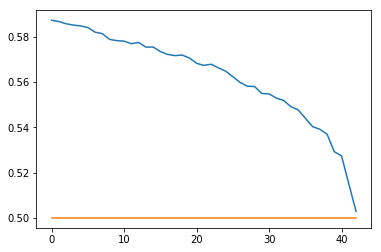

In [20]:
plt.plot(auc)
plt.plot(len(auc)*[0.5])
plt.show()

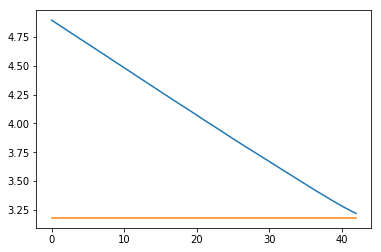

In [21]:
plt.plot(ratio)
plt.plot(len(ratio)*[3.18])
plt.show()

[KstestResult(statistic=0.6386075931551443, pvalue=0.0), KstestResult(statistic=0.6446364149299244, pvalue=0.0), KstestResult(statistic=0.6509508838101734, pvalue=0.0), KstestResult(statistic=0.6567073206826735, pvalue=0.0), KstestResult(statistic=0.6595999072826748, pvalue=0.0), KstestResult(statistic=0.6673908676243939, pvalue=0.0), KstestResult(statistic=0.6762546650064379, pvalue=0.0), KstestResult(statistic=0.678808369415598, pvalue=0.0), KstestResult(statistic=0.6852601708387676, pvalue=0.0), KstestResult(statistic=0.6945834094057186, pvalue=0.0), KstestResult(statistic=0.7003454138018801, pvalue=0.0), KstestResult(statistic=0.7087175064908061, pvalue=0.0), KstestResult(statistic=0.714557929221401, pvalue=0.0), KstestResult(statistic=0.7212581030497024, pvalue=0.0), KstestResult(statistic=0.7278591882663066, pvalue=0.0), KstestResult(statistic=0.7354524585872884, pvalue=0.0), KstestResult(statistic=0.742535189710478, pvalue=0.0), KstestResult(statistic=0.7499781583889121, pvalue=

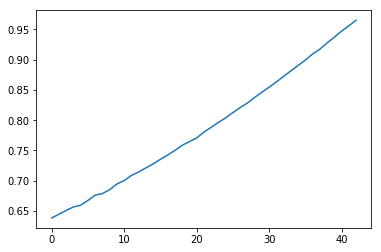

In [22]:
print(ks)
plt.plot([a[0] for a in ks])

In [23]:
data

Above/Below 50K Age  Capital Gain  Capital Loss  Country_ ?  \
0               <=50K  39        2174.0           0.0           0   
1               <=50K  50           0.0           0.0           0   
2               <=50K  38           0.0           0.0           0   
3               <=50K  53           0.0           0.0           0   
4               <=50K  28           0.0           0.0           0   
5               <=50K  37           0.0           0.0           0   
6               <=50K  49           0.0           0.0           0   
7                >50K  52           0.0           0.0           0   
8                >50K  31       14084.0           0.0           0   
9                >50K  42        5178.0           0.0           0   
10               >50K  37           0.0           0.0           0   
11               >50K  30           0.0           0.0           0   
12              <=50K  23           0.0           0.0           0   
13              <=50K  32           0.0           0.0           0   
14               >50K  40           0.0           0.0           1   
15              <=50K  34           0.0           0.0           0   
16              <=50K  25           0.0           0.0           0   
17              <=50K  32           0.0           0.0           0   
18              <=50K  38           0.0           0.0           0   
19               >50K  43           0.0           0.0           0   
20               >50K  40           0.0           0.0           0   
21              <=50K  54           0.0           0.0           0   
22              <=50K  35           0.0           0.0           0   
23              <=50K  43           0.0        2042.0           0   
24              <=50K  59           0.0           0.0           0   
25               >50K  56           0.0           0.0           0   
26              <=50K  19           0.0           0.0           0   
27               >50K  54           0.0           0.0           0   
28              <=50K  39           0.0           0.0           0   
29              <=50K  49           0.0           0.0           0   
...               ...  ..           ...           ...         ...   
49296           <=50K  24           0.0           0.0           0   
49297           <=50K  46           0.0           0.0           0   
49298           <=50K  48           0.0           0.0           0   
49299           <=50K  20           0.0           0.0           0   
49300           <=50K  27           0.0           0.0           0   
49301           <=50K  19           0.0           0.0           0   
49302           <=50K  31           0.0           0.0           0   
49303           <=50K  35           0.0           0.0           0   
49304           <=50K  39           0.0           0.0           0   
49305           <=50K  48           0.0           0.0           0   
49306           <=50K  58           0.0           0.0           0   
49307           <=50K  50           0.0           0.0           0   
49308           <=50K  61           0.0           0.0           0   
49309           <=50K  48           0.0           0.0           0   
49310           <=50K  41           0.0           0.0           0   
49311           <=50K  24           0.0           0.0           0   
49312           <=50K  46           0.0           0.0           0   
49313           <=50K  40           0.0           0.0           0   
49314           <=50K  23           0.0           0.0           0   
49315           <=50K  26           0.0           0.0           0   
49316           <=50K  36           0.0           0.0           0   
49317           <=50K  59           0.0           0.0           0   
49318           <=50K  28           0.0           0.0           0   
49319           <=50K  49           0.0           0.0           0   
49320            >50K  44       15024.0           0.0           0   
49321            >50K  37           0.0           0.0           0   
4932

In [ ]:
 <=50K    37155
 >50K     11687
Name: Above/Below 50K, dtype: int64
 <=50K    21000
 >50K     11687
Name: Above/Below 50K, dtype: int64

In [24]:
print(data['Above/Below 50K'].value_counts())

 <=50K    37633
 >50K     11693
Name: Above/Below 50K, dtype: int64


In [25]:
data[data.label == 'nonrep']['Above/Below 50K'].value_counts()

 <=50K    478
 >50K       6
Name: Above/Below 50K, dtype: int64